
# Hopfield-vs-Hamming: Associative Memory vs. Linear Codes

This notebook compares two paradigms of error correction and memory storage
on small binary patterns:

1. A **linear (7,4) Hamming code**, with strict distance guarantees and
   algebraic decoding.
2. A **Hopfield network** storing a small set of 7-bit patterns as attractors
   and retrieving them via energy descent.

We will:

- Generate random 4-bit messages and encode them with the (7,4) Hamming code.
- Store a small set of corresponding 7-bit codewords as patterns in a
  Hopfield network.
- Corrupt the codewords with random bit flips at varying noise levels.
- Compare how often each method (Hamming decoding vs. Hopfield retrieval)
  recovers the original pattern correctly.

All figures are both displayed and saved into the local `figs/` directory,
so that they can be included in a LaTeX manuscript.


In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("figs", exist_ok=True)
print("Using NumPy version:", np.__version__)


Using NumPy version: 1.24.3


In [3]:

# -------------------------------------------------------------------------
# 1. (7,4) Hamming code: generator and parity-check matrices
# -------------------------------------------------------------------------
# We use the standard (7,4) Hamming code in systematic form.

G = np.array([
    [1, 0, 0, 0, 0, 1, 1],
    [0, 1, 0, 0, 1, 0, 1],
    [0, 0, 1, 0, 1, 1, 0],
    [0, 0, 0, 1, 1, 1, 1],
], dtype=int)

# Parity-check matrix H satisfies H c^T = 0 (mod 2) for all codewords c.
H = np.array([
    [0, 1, 1, 1, 1, 0, 0],
    [1, 0, 1, 1, 0, 1, 0],
    [1, 1, 0, 1, 0, 0, 1],
], dtype=int)

print("Generator matrix G:\\n", G)
print("\\nParity-check matrix H:\\n", H)

def hamming_encode(m):
    # Encode a 4-bit message m (1D array of length 4 with entries 0/1) into a 7-bit codeword
    m = np.asarray(m, dtype=int).reshape(1, 4)
    c = (m @ G) % 2
    return c.reshape(-1)

# Precompute syndrome -> error position map for single-bit errors
syndrome_to_pos = {}
n = 7
for pos in range(n):
    e = np.zeros(n, dtype=int)
    e[pos] = 1
    s = (H @ e) % 2
    key = tuple(s.tolist())
    syndrome_to_pos[key] = pos

def hamming_decode(received):
    """Decode a 7-bit received vector using syndrome decoding.

    Returns:
        decoded_message (length 4 array)
        corrected_codeword (length 7 array)
    """
    r = np.asarray(received, dtype=int).reshape(-1)
    s = (H @ r) % 2
    s_tuple = tuple(s.tolist())
    if any(s) and s_tuple in syndrome_to_pos:  # non-zero syndrome
        err_pos = syndrome_to_pos[s_tuple]
        r = r.copy()
        r[err_pos] ^= 1  # flip bit
    # Extract the first 4 bits as systematic data bits
    m_hat = r[:4]
    return m_hat, r


Generator matrix G:\n [[1 0 0 0 0 1 1]
 [0 1 0 0 1 0 1]
 [0 0 1 0 1 1 0]
 [0 0 0 1 1 1 1]]
\nParity-check matrix H:\n [[0 1 1 1 1 0 0]
 [1 0 1 1 0 1 0]
 [1 1 0 1 0 0 1]]


In [4]:

# -------------------------------------------------------------------------
# 2. Hopfield network storing 7-bit patterns as attractors
# -------------------------------------------------------------------------
def binary_to_pm1(x_bin):
    # Convert {0,1} vector to {-1,+1} representation.
    x_bin = np.asarray(x_bin, dtype=int)
    return 2 * x_bin - 1

def pm1_to_binary(x_pm1):
    # Convert {-1,+1} vector back to {0,1}.
    x_pm1 = np.asarray(x_pm1)
    return ((x_pm1 + 1) // 2).astype(int)

class HopfieldNetwork:
    def __init__(self, patterns):
        """Initialize Hopfield weights from a list/array of stored patterns.

        patterns: array of shape (num_patterns, n) with entries in {-1,+1}
        """
        P = np.asarray(patterns, dtype=float)
        self.n = P.shape[1]
        # Hebbian learning: W = sum_k x^k (x^k)^T, with zero diagonal
        W = P.T @ P
        np.fill_diagonal(W, 0.0)
        self.W = W / self.n  # optional normalization

    def energy(self, x):
        # Hopfield energy E(x) = -1/2 x^T W x.
        x = np.asarray(x, dtype=float).reshape(-1)
        return -0.5 * x @ (self.W @ x)

    def update_async(self, x, max_steps=20):
        """Asynchronous stochastic-order update until convergence or max_steps.

        Returns:
            x_final, energies (list of energy values across updates)
        """
        x = np.asarray(x, dtype=float).reshape(-1)
        energies = [self.energy(x)]
        for _ in range(max_steps):
            i = np.random.randint(self.n)
            h_i = np.dot(self.W[i], x)
            x[i] = 1.0 if h_i >= 0.0 else -1.0
            E = self.energy(x)
            energies.append(E)
            # simple convergence check: if energy stops changing
            if len(energies) > 3 and np.isclose(energies[-1], energies[-2]):
                break
        return x, energies


Example message m: [0 1 1 0]
Hamming codeword c: [0 1 1 0 0 1 1]
Noisy received codeword (1-bit flip): [0 1 1 0 0 1 0]
Hopfield recovered: [0 1 1 0 0 1 1]
Energy trajectory: [-1.2857142857142856, -1.2857142857142856, -1.2857142857142856, -2.9999999999999996, -2.9999999999999996]
Saved figure to figs/hopfield_energy_single_trial.png


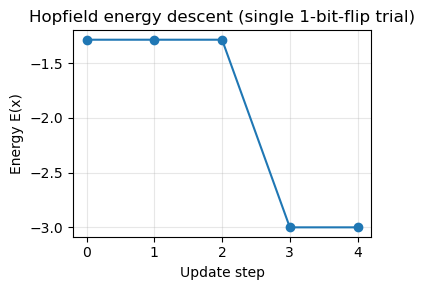

In [5]:

# -------------------------------------------------------------------------
# 3. Add noise and run a single illustrative trial
# -------------------------------------------------------------------------
rng = np.random.default_rng(123)

def flip_bits(x, p, rng):
    # Flip each bit of a {0,1} vector independently with probability p.
    x = np.asarray(x, dtype=int)
    flips = rng.random(x.shape) < p
    y = x.copy()
    y[flips] ^= 1
    return y

# Example: one random message, encode, store in Hopfield, corrupt, retrieve
m = rng.integers(0, 2, size=4)
c = hamming_encode(m)

print("Example message m:", m)
print("Hamming codeword c:", c)

# Build Hopfield on a single stored pattern (c)
pattern_pm1 = binary_to_pm1(c)
hopfield_single = HopfieldNetwork(patterns=np.array([pattern_pm1]))

# Corrupt with exactly one random bit flip (inside the basin of attraction)
c_noisy = c.copy()
flip_index = rng.integers(0, len(c_noisy))
c_noisy[flip_index] ^= 1
x0 = binary_to_pm1(c_noisy)

print("Noisy received codeword (1-bit flip):", c_noisy)

x_final, energies = hopfield_single.update_async(x0, max_steps=20)
c_recovered = pm1_to_binary(x_final)

print("Hopfield recovered:", c_recovered)
print("Energy trajectory:", energies)

# Plot energy trajectory for this illustrative trial
plt.figure(figsize=(4, 3))
plt.plot(range(len(energies)), energies, marker="o")
plt.xlabel("Update step")
plt.ylabel("Energy E(x)")
plt.title("Hopfield energy descent (single 1-bit-flip trial)")
plt.grid(alpha=0.3)
plt.tight_layout()
savepath = "figs/hopfield_energy_single_trial.png"
plt.savefig(savepath, dpi=150, bbox_inches="tight")
print(f"Saved figure to {savepath}")
plt.show()


In [6]:

# -------------------------------------------------------------------------
# 4. Main experiment: success rate vs noise level p
# -------------------------------------------------------------------------
noise_levels = np.linspace(0.0, 0.3, 7)  # 0.00, 0.05, ..., 0.30
num_trials = 500

# Choose a small set of messages to store (to avoid overloading Hopfield)
K = 2
stored_messages = rng.integers(0, 2, size=(K, 4))
stored_codewords = np.array([hamming_encode(m) for m in stored_messages])
hop_patterns_pm1 = np.array([binary_to_pm1(cw) for cw in stored_codewords])

print("Stored messages (for Hopfield):")
print(stored_messages)
print("Stored codewords (for Hopfield):")
print(stored_codewords)

# Hopfield network storing these K codewords as attractors
hopfield = HopfieldNetwork(patterns=hop_patterns_pm1)

hamming_success = []
hopfield_success = []

for p in noise_levels:
    succ_hamming = 0
    succ_hopfield = 0

    for _ in range(num_trials):
        # Sample one of the stored messages uniformly
        idx = rng.integers(0, K)
        m = stored_messages[idx]
        c = stored_codewords[idx]

        # Corrupt codeword
        c_noisy = flip_bits(c, p, rng)

        # Hamming decode
        m_hat, c_hat = hamming_decode(c_noisy)
        if np.array_equal(m_hat, m):
            succ_hamming += 1

        # Hopfield retrieval
        x0 = binary_to_pm1(c_noisy)
        x_final, _ = hopfield.update_async(x0, max_steps=20)
        c_rec = pm1_to_binary(x_final)
        if np.array_equal(c_rec, c):
            succ_hopfield += 1

    hamming_success.append(succ_hamming / num_trials)
    hopfield_success.append(succ_hopfield / num_trials)
    print(f"p={p:.2f}: Hamming={hamming_success[-1]:.3f}, Hopfield={hopfield_success[-1]:.3f}")


Stored messages (for Hopfield):
[[0 0 0 0]
 [0 0 1 0]]
Stored codewords (for Hopfield):
[[0 0 0 0 0 0 0]
 [0 0 1 0 1 1 0]]
p=0.00: Hamming=1.000, Hopfield=1.000
p=0.05: Hamming=0.964, Hopfield=0.772
p=0.10: Hamming=0.858, Hopfield=0.642
p=0.15: Hamming=0.724, Hopfield=0.492
p=0.20: Hamming=0.574, Hopfield=0.386
p=0.25: Hamming=0.420, Hopfield=0.282
p=0.30: Hamming=0.328, Hopfield=0.220


Saved figure to figs/hopfield_vs_hamming_success_vs_noise.png


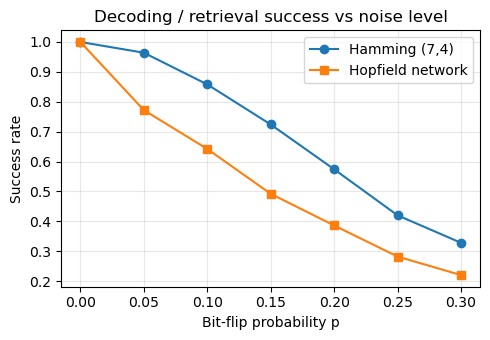

In [7]:

# -------------------------------------------------------------------------
# 5. Plot success probability vs noise level
# -------------------------------------------------------------------------
plt.figure(figsize=(5, 3.5))
plt.plot(noise_levels, hamming_success, marker="o", label="Hamming (7,4)")
plt.plot(noise_levels, hopfield_success, marker="s", label="Hopfield network")
plt.xlabel("Bit-flip probability p")
plt.ylabel("Success rate")
plt.title("Decoding / retrieval success vs noise level")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
savepath = "figs/hopfield_vs_hamming_success_vs_noise.png"
plt.savefig(savepath, dpi=150, bbox_inches="tight")
print(f"Saved figure to {savepath}")
plt.show()



## Summary and Discussion

In this notebook we compared:

- A **(7,4) Hamming code**, which provides formal guarantees: up to one bit
  flip can always be corrected, as reflected in its high success rate for
  small noise levels.
- A **Hopfield network** storing a small set of 7-bit codewords as
  attractors. It can often recover from corrupted inputs via energy descent,
  but lacks the strict correction radius guarantees of the Hamming code.

As the bit-flip probability \(p\) increases, the success rate of both
methods decreases, but in different ways. The Hamming code shows a sharp
transition tied to its distance properties, while the Hopfield network
degrades more smoothly and can fail by converging to the wrong attractor.

This illustrates a key contrast between **associative memory** models and
**linear error-correcting codes**:

- Hopfield networks offer flexible, distributed storage and brain-inspired
  dynamics, but only heuristic error-correction performance.
- Linear codes, in contrast, provide rigorous guarantees, making them the
  standard tool for engineered communication systems.

Together with the channel-coding perspective, this example highlights how
ideas from information theory and statistical physics help us reason about
the capabilities and limitations of neural-network-based memory.
